# Предсказание доходности месторождений
## Постановка задачи:

Исходные данные:

In [1]:

import sys
sys.path.append('../')
from stable_gnn.graph import Graph
from stable_gnn.pipelines.node_classification_pipeline import TrainModelNC, TrainModelOptunaNC

import torch_geometric.transforms as T
import torch
from torch_geometric.utils import homophily


In [2]:
root = '../data_validation/'
name='oil_fields'
dataset = Graph(root=root + str(name), name=name, transform=T.NormalizeFeatures(),adjust_flag=False)
data = dataset[0]
len(data.edge_index[0])

Processing...
Done!


11186

In [3]:
homophily(data.edge_index,data.y)

0.3484713137149811

Решаем задачу предсказания связей, пользуясь подготовленным пайплайном в stable_gnn.pipelines.train_model_pipeline

[I 2022-12-29 16:19:14,533] A new study created in memory with name: no-name-c9ae0c85-0533-4d57-82a0-8603615d97ad
[I 2022-12-29 16:19:14,639] A new study created in memory with name: no-name-c957afd7-b060-4e6b-8cfc-7074a2267cc7
[I 2022-12-29 16:19:24,562] Trial 0 finished with value: 4.926243305206299 and parameters: {'hidden_layer': 32, 'dropout': 0.4, 'size of network, number of convs': 3, 'lr': 0.006165587732998073, 'num_negative_samples': 21, 'alpha': 0.8}. Best is trial 0 with value: 4.926243305206299.
[I 2022-12-29 16:19:30,340] Trial 1 finished with value: 5.224925994873047 and parameters: {'hidden_layer': 64, 'dropout': 0.4, 'size of network, number of convs': 2, 'lr': 0.009185275222776223, 'num_negative_samples': 16, 'alpha': 0.9}. Best is trial 0 with value: 4.926243305206299.
[I 2022-12-29 16:19:39,167] Trial 2 finished with value: 4.454012870788574 and parameters: {'hidden_layer': 128, 'dropout': 0.5, 'size of network, number of convs': 1, 'lr': 0.005307781637888925, 'num_n

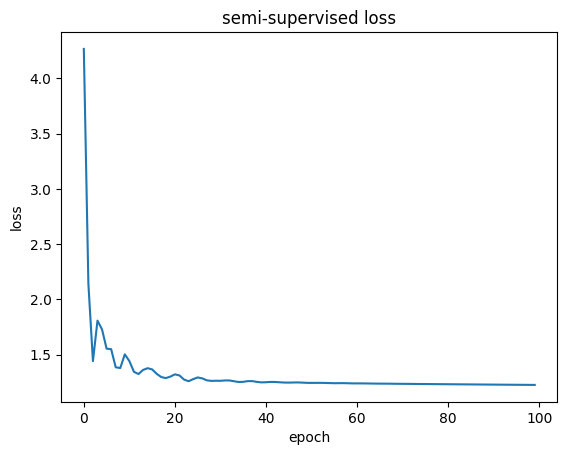

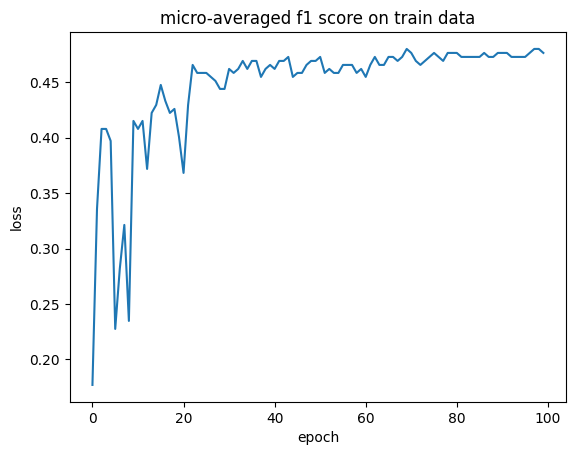

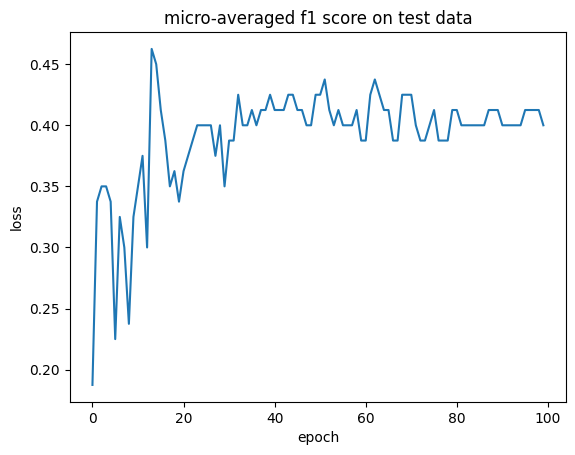

0.47653429602888087 0.4


In [4]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
loss_name='APP'
ssl_flag = False

otuna_training = TrainModelOptunaNC(data=dataset, device=device, ssl_flag=ssl_flag, loss_name=loss_name)
params = otuna_training.run(number_of_trials=50) #{'hidden_layer': 128, "size of network, number of convs": 3, "dropout": 0.1, "lr": 0.01, "coef":10}
model_training = TrainModelNC(data=dataset, device=device, ssl_flag=ssl_flag, loss_name=loss_name)
model, train_acc_mi, train_acc_ma, test_acc_mi, test_acc_ma = model_training.run(params, plot_training_procces=True)
print(train_acc_mi, test_acc_mi)

[I 2022-12-29 16:40:23,813] A new study created in memory with name: no-name-ecc9cbf7-5fbc-465d-b7cb-f686181e56a4
[I 2022-12-29 16:40:27,895] Trial 0 finished with value: 0.3076923076923077 and parameters: {'hidden_layer': 256, 'dropout': 0.4, 'size of network, number of convs': 1, 'lr': 0.006793619442788133, 'coef': 5}. Best is trial 0 with value: 0.3076923076923077.
[I 2022-12-29 16:40:35,634] Trial 1 finished with value: 0.07692307692307693 and parameters: {'hidden_layer': 128, 'dropout': 0.2, 'size of network, number of convs': 2, 'lr': 0.008262287975434797, 'coef': 2}. Best is trial 0 with value: 0.3076923076923077.
[I 2022-12-29 16:40:43,453] Trial 2 finished with value: 0.15384615384615385 and parameters: {'hidden_layer': 64, 'dropout': 0.30000000000000004, 'size of network, number of convs': 2, 'lr': 0.0053623540544965815, 'coef': 2}. Best is trial 0 with value: 0.3076923076923077.
[I 2022-12-29 16:40:51,098] Trial 3 finished with value: 0.3076923076923077 and parameters: {'hid

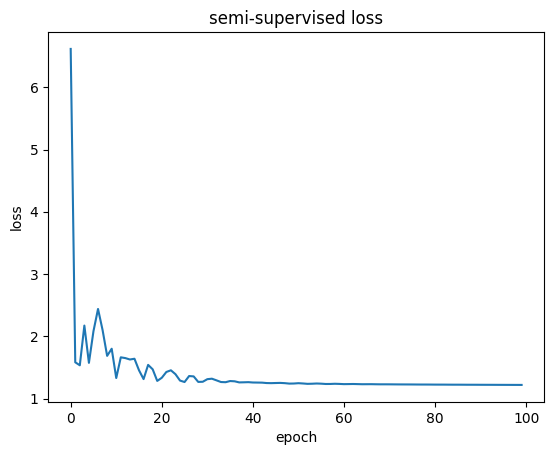

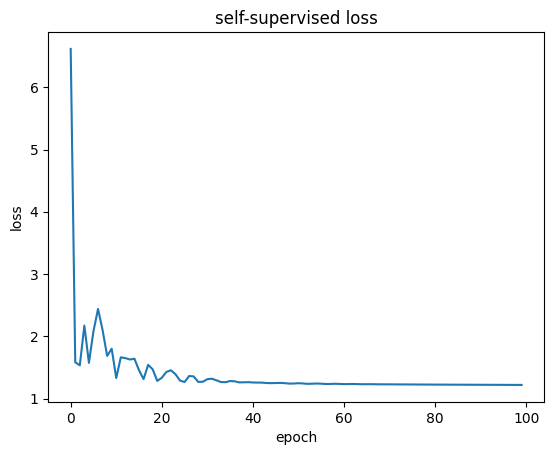

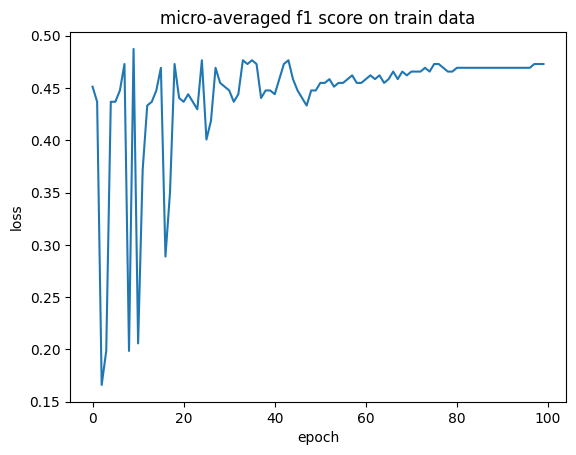

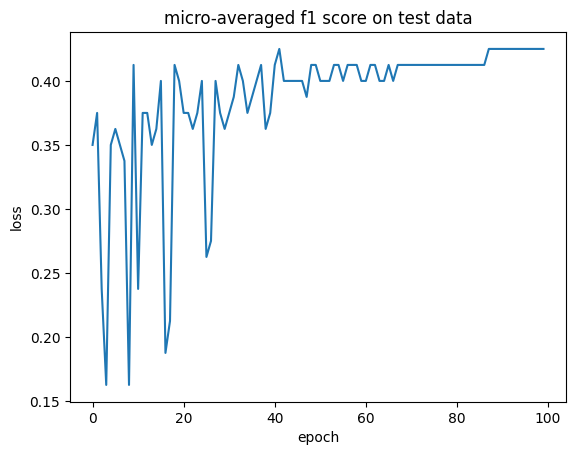

0.4729241877256318 0.425


In [5]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loss_name='APP'
ssl_flag = True

otuna_training = TrainModelOptunaNC(data=dataset, device=device, ssl_flag=ssl_flag, loss_name=loss_name)
params = otuna_training.run(number_of_trials=50) #{'hidden_layer': 128, "size of network, number of convs": 3, "dropout": 0.1, "lr": 0.01, "coef":10}
model_training = TrainModelNC(data=dataset, device=device, ssl_flag=ssl_flag, loss_name=loss_name)
model, train_acc_mi, train_acc_ma, test_acc_mi, test_acc_ma = model_training.run(params, plot_training_procces=True)
print(train_acc_mi, test_acc_mi)

# Если уточнить структуру
удалим датасет и загрузим снова с другим флагом:

In [7]:
root = '../data_validation/'
name='oil_fields'
dataset = Graph(root=root + str(name), name=name, transform=T.NormalizeFeatures(),adjust_flag=True,number_of_trainig_epochs=120)
data = dataset[0]

print(len(data.edge_index[0]))

Processing...


7698


Done!


[I 2022-12-29 16:48:38,604] A new study created in memory with name: no-name-141f4d92-53c8-4240-9c2b-00644979b7ca
[I 2022-12-29 16:48:38,610] A new study created in memory with name: no-name-fafad9ed-6ebe-4b19-98ea-65b8dd6a94a4
[I 2022-12-29 16:48:46,213] Trial 0 finished with value: 2.691890239715576 and parameters: {'hidden_layer': 32, 'dropout': 0.1, 'size of network, number of convs': 2, 'lr': 0.005363303741181892, 'num_negative_samples': 21, 'alpha': 0.8}. Best is trial 0 with value: 2.691890239715576.
[I 2022-12-29 16:49:03,241] Trial 1 finished with value: 1.7955039739608765 and parameters: {'hidden_layer': 128, 'dropout': 0.2, 'size of network, number of convs': 2, 'lr': 0.008079849329947226, 'num_negative_samples': 16, 'alpha': 0.1}. Best is trial 1 with value: 1.7955039739608765.
[I 2022-12-29 16:49:21,398] Trial 2 finished with value: 1.846395492553711 and parameters: {'hidden_layer': 64, 'dropout': 0.1, 'size of network, number of convs': 3, 'lr': 0.007404224968852156, 'num

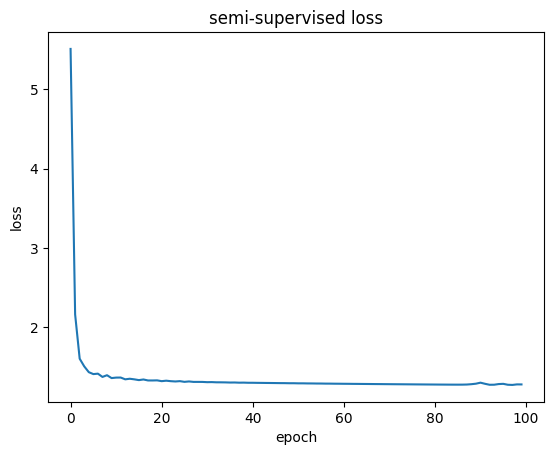

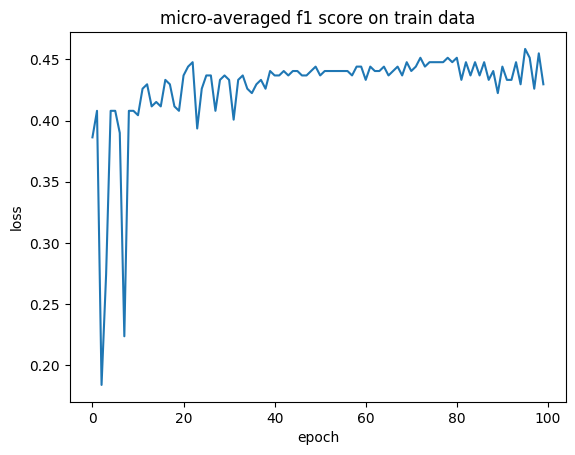

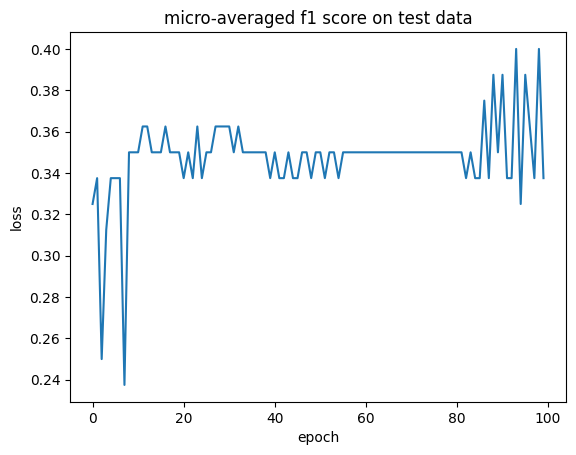

0.4296028880866426 0.3375


In [9]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loss_name='APP'
ssl_flag = False

otuna_training = TrainModelOptunaNC(data=dataset, device=device, ssl_flag=ssl_flag, loss_name=loss_name)
params = otuna_training.run(number_of_trials=50) #{'hidden_layer': 128, "size of network, number of convs": 3, "dropout": 0.1, "lr": 0.01, "coef":10}
model_training = TrainModelNC(data=dataset, device=device, ssl_flag=ssl_flag, loss_name=loss_name)
model, train_acc_mi, train_acc_ma, test_acc_mi, test_acc_ma = model_training.run(params, plot_training_procces=True)
print(train_acc_mi, test_acc_mi)

[I 2022-12-29 17:04:36,303] A new study created in memory with name: no-name-8398ee2a-dc90-447e-a789-398502038f03
[I 2022-12-29 17:04:45,106] Trial 0 finished with value: 0.3076923076923077 and parameters: {'hidden_layer': 32, 'dropout': 0.4, 'size of network, number of convs': 3, 'lr': 0.006505229548741256, 'coef': 2}. Best is trial 0 with value: 0.3076923076923077.
[I 2022-12-29 17:04:51,060] Trial 1 finished with value: 0.1794871794871795 and parameters: {'hidden_layer': 64, 'dropout': 0.0, 'size of network, number of convs': 2, 'lr': 0.0077973913939253505, 'coef': 2}. Best is trial 0 with value: 0.3076923076923077.
[I 2022-12-29 17:05:01,324] Trial 2 finished with value: 0.02564102564102564 and parameters: {'hidden_layer': 256, 'dropout': 0.1, 'size of network, number of convs': 3, 'lr': 0.006992662969374289, 'coef': 10}. Best is trial 0 with value: 0.3076923076923077.
[I 2022-12-29 17:05:04,390] Trial 3 finished with value: 0.46153846153846156 and parameters: {'hidden_layer': 256,

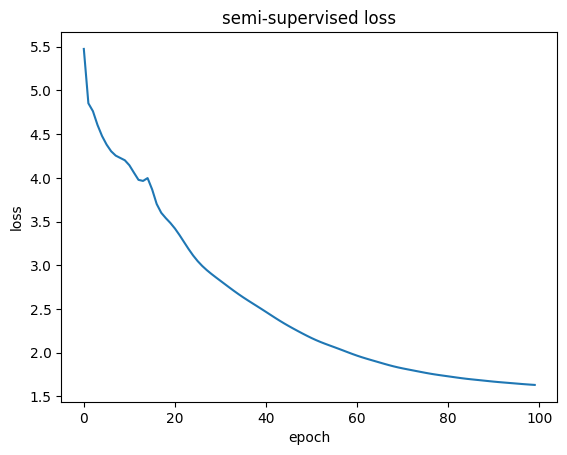

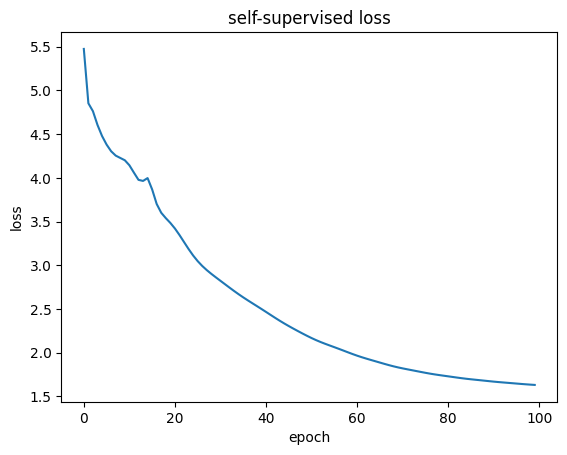

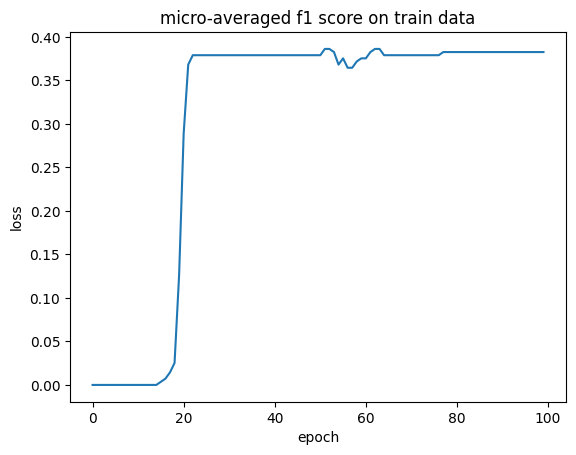

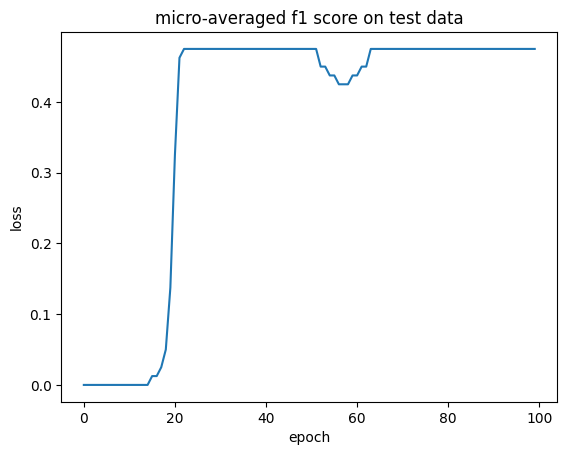

0.38267148014440433 0.475


In [10]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loss_name='APP'
ssl_flag = True
otuna_training = TrainModelOptunaNC(data=dataset, device=device, ssl_flag=ssl_flag, loss_name=loss_name)
params = otuna_training.run(number_of_trials=50) #{'hidden_layer': 128, "size of network, number of convs": 3, "dropout": 0.1, "lr": 0.01, "coef":10}
model_training = TrainModelNC(data=dataset, device=device, ssl_flag=ssl_flag, loss_name=loss_name)
model, train_acc_mi, train_acc_ma, test_acc_mi, test_acc_ma = model_training.run(params, plot_training_procces=True)
print(train_acc_mi, test_acc_mi)

# Построим объяснения предсказания

In [ ]:
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from torch_geometric.utils import to_dense_adj

from stable_gnn.explain import Explain

root='../data_validation/'
features = np.load(root + name + "/X.npy")
if os.path.exists(root + name + "/A.npy"):
    adj_matrix = np.load(root + name + "/A.npy")
else:
    adj_matrix = torch.squeeze(to_dense_adj(data.edge_index.cpu())).numpy()


explainer = Explain(model=model, adj_matrix=adj_matrix, features=features)

for global_node in [0,7]:
        pgm_explanation = explainer.structure_learning(global_node)
        print("explanations is", global_node, pgm_explanation.nodes, pgm_explanation.edges)
        g = nx.DiGraph()
        mapping = {}
        inv_mapping = {}
        for i, node in enumerate(pgm_explanation.nodes):
            mapping[node]=i
            inv_mapping[i]=node

        edges = []
        for edge in pgm_explanation.edges:
            edges.append([mapping[edge[0]], mapping[edge[1]]])
        g.add_edges_from(edges)
        for node in g.nodes():
            print(node)
            g.add_node(node)

        plt.figure()
        nx.draw(g)
        plt.title(str(global_node)+'\'s explanation' )
        plt.show()
        plt.close()

# Ego-networks of these nodes

In [ ]:
edges = data.edge_index.T.tolist()
G = nx.Graph()
G.add_edges_from(edges)
G.remove_edges_from(nx.selfloop_edges(G))

for global_node in [0,7]:
    g = nx.ego_graph(G,global_node)
    plt.figure()
    nx.draw(g)
    plt.title(str(global_node)+'\'s ego-network' )
    plt.show()
    plt.close()